Test of RC12a (alpha before release). Quick Frame

In [1]:
from typing import Final
TEST_NAME: Final = "img_RC12__FM1__CleanRoomImage"
stream_via_ipc_first: bool = True
LINE_WIDTH: Final = 6 * 512  # DLing all pages in a line in case of shift (extra space doesn't matter much when compressed)

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
# Load scripting environment:
from scripts.testing.ipc_demo.image_builder_demo import *

2023-10-23 01:54:44: INFO     Successfully Loaded 22 Modules with 76 Commands, 188 Channels, and 92 Events from ./out/DataStandardsCache/IBv3_datastandards_01HDCDYT8M6JXK66JSPAE54S5E.dsc .
2023-10-23 01:54:44: NOTICE   IRIS Lunar Rover - FileBuilderDemo - IPC App Started
2023-10-23 01:54:44: VERBOSE  Using default binding scheme (`bind=False`) for `socket_type=<SocketType.SUBSCRIBER: 3>`.
2023-10-23 01:54:44: INFO     Created a `SocketType.SUBSCRIBER` connected to `tcp://127.0.0.1` on ports `[<Port.TRANSCEIVER_SUB: 61454>]` (`0xF00E`).
2023-10-23 01:54:44: VERBOSE  Subscribing `sub` to: [<Topic.DL_PAYLOADS: b'\xfe\xee'>] . . .


]0;FileBuilderDemo


In [4]:
import time
from types import SimpleNamespace
from typing import Final
from IrisBackendv3.codec.payload import EventPayload

DOWNLINK_END_EVENT_NAME: Final = 'CameraImageDownlinkComplete'
# Max amount of time since last block before we just consider the image done:
BLOCK_WAIT_TIMEOUT_SEC: Final = 5.0

if stream_via_ipc_first:
    # Mimic CLI args:
    opts = SimpleNamespace()
    opts.interp = False
    opts.debayer = False

    decoder = BasicImageDecoder.new_empty()
    decoder.FILE_PREFIX = TEST_NAME

    started: bool = False
    done: bool = False
    last_block_time_sec: float = 0
    first_block_time: float = 0
    
    # Stream file blocks into decoder:
    while not done:
        # Stream packets until done event or TIMEOUT since last file block:
        ipc_payload = manager.read('sub')
        try:
            msg = ipc.guard_msg(ipc_payload.message,
                                DownlinkedPayloadsMessage)
            payloads = msg.content.payloads
        except Exception as e:
            app.logger.error(
                f"Failed to decode IPC message `{msg}` "
                f"of `{ipc_payload=}` b/c: `{e}`."
            )
        blocks = [*payloads[FileBlockPayload]]
        if len(blocks) > 0:
            if not started:
                started = True  # we've stared to received File data
                first_block_time = time.time()
            last_block_time_sec = time.time()
        for block in payloads[FileBlockPayload]:
            block = cast(FileBlockPayload, block)
            decoder.process_file_block(block)
        
        # Check for stop condition:
        if started and len([e for e in payloads[EventPayload] if e.event.name == DOWNLINK_END_EVENT_NAME]) > 0:
            app.logger.notice(f"Finished image b/c Downlink End Event: `{DOWNLINK_END_EVENT_NAME}`.")
            done = True
        if started and (time.time() - last_block_time_sec) > BLOCK_WAIT_TIMEOUT_SEC:
            app.logger.notice(f"Finished image b/c Block Wait Timeout > {BLOCK_WAIT_TIMEOUT_SEC:.2f}s.")
            done = True

    app.logger.success(f"Image Downlinked in {time.time()-first_block_time:.3f}s.")

    # Build file memory (image build happens below):
    decoder.export_all_raw()

2023-10-23 02:19:55: INFO     	1 Lines Complete . . .
2023-10-23 02:19:55: INFO     	2 Lines Complete . . .
2023-10-23 02:19:55: INFO     	3 Lines Complete . . .
2023-10-23 02:19:55: INFO     	4 Lines Complete . . .
2023-10-23 02:19:55: INFO     	5 Lines Complete . . .
2023-10-23 02:19:55: INFO     	6 Lines Complete . . .
2023-10-23 02:19:55: INFO     	7 Lines Complete . . .
2023-10-23 02:19:56: INFO     	8 Lines Complete . . .
2023-10-23 02:19:56: INFO     	9 Lines Complete . . .
2023-10-23 02:19:56: INFO     	10 Lines Complete . . .
2023-10-23 02:19:56: INFO     	11 Lines Complete . . .
2023-10-23 02:19:56: INFO     	12 Lines Complete . . .
2023-10-23 02:19:56: INFO     	13 Lines Complete . . .
2023-10-23 02:19:56: INFO     	14 Lines Complete . . .
2023-10-23 02:19:56: INFO     	15 Lines Complete . . .
2023-10-23 02:19:57: INFO     	16 Lines Complete . . .
2023-10-23 02:19:57: INFO     	17 Lines Complete . . .
2023-10-23 02:19:57: INFO     	18 Lines Complete . . .
2023-10-23 02:19:57

In [5]:
manager.__del__() # Make sure all the IPC stuff isn't left up

2023-10-23 02:20:28: NOTICE   Closing App's IPC socket(s) and context . . .


In [6]:
# Reload archive Pickle:
import glob
archive_ext = '.image.pkl'
test_folder = f'*{TEST_NAME}*'
archive_regex = f'./out/image_file_decodings/{test_folder}/*{archive_ext}'
image_pickle_file = glob.glob(archive_regex)[0]
with open(image_pickle_file, 'rb') as ipf:
    reloaded_img: Image = pickle.load(ipf)


In [7]:
# Extract notes from folder name:
image_pickle_file.split('/')[-2].replace('__', '. ').replace('_', ' ')

'img img RC12a 12.5.3. PreTest. QuickFrame. 01HDDK17X3PSSWF0TY94DHJYKD. 16562'

In [8]:
print('\n'.join(reloaded_img.report()))

File Group (Image) ID:	 16562
Image Valid / Internally Consistent:	 True
Image Complete:	 False
Total Image Lines:	 1944
Lines Found:	 301
Lines w/ Metadata:	 5
Lines Completed:	 301
Invalid / Internally Inconsistent Lines:	 0
Lines with Corrupted Data:	 0


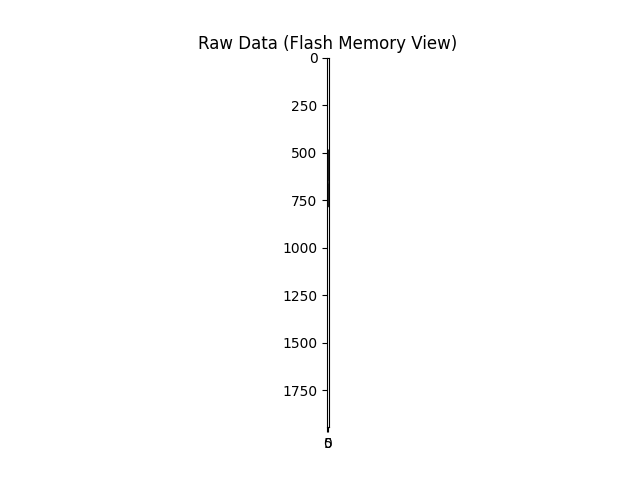

In [9]:
# Build raw image:
lines_data = reloaded_img.assemble(equalize_lengths=True, pad_byte=b'\xAA')
lines_data_orig_copy = [x for x in lines_data]  # Copy of source to compare against
lines_arr = [[int(x) for x in l] for l in lines_data]
raw_img = np.array(lines_arr, dtype=np.uint8)
plt.figure()
plt.imshow(raw_img, cmap='gray')
plt.title('Raw Data (Flash Memory View)')
plt.show()

In [10]:
import scripts.toolkit.rc11_image_toolkit as img11
import scripts.toolkit.image_compression_toolkit as ic
import PIL.Image
import time

FrameMetadataRc11(fw_versions=Counter(), sensor_frame_nums=[], interleaved_frame_nums=[], imaging_mode=Counter())


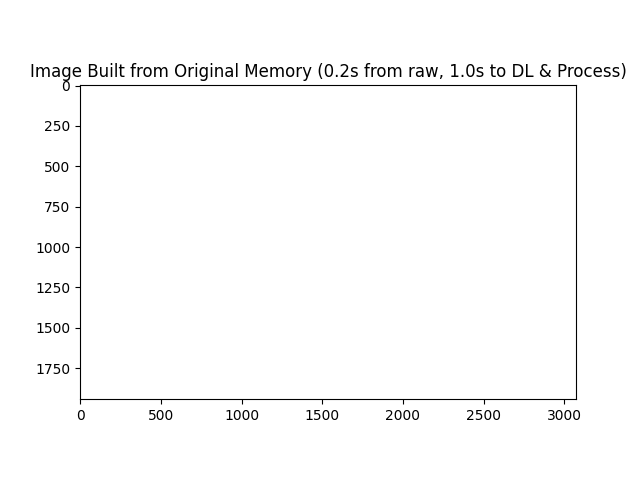

In [11]:
## Build Image using Original Memory:
start_sec = time.time()
compressed_lines = reloaded_img.assemble(equalize_lengths=False)
# Decompress Flash Memory (if needed):
decompressed_lines = [ic.decompress(cl) for cl in compressed_lines if len(cl) > 0]
# Then rebuild the image from the (reconstructed) flash:
image_data = img11.extract_image_from_flash_memory(b''.join(decompressed_lines), LINE_WIDTH)
print(image_data.frame_metadata)
image = image_data.quick_build()
end_sec = time.time()
est_dl_n_processing_time = sum(len(x) for x in compressed_lines) * 3.5/243/2592*60 + (end_sec - start_sec)
plt.figure()
plt.imshow(image, cmap='gray')
plt.title(f'Image Built from Original Memory ({end_sec-start_sec:.01f}s from raw, {est_dl_n_processing_time:.1f}s to DL & Process)')
plt.show()

In [12]:
# Display Compression Statistics:
# Compress:
orig_size = sum(len(l) for l in decompressed_lines)
comp_size = sum(len(l) for l in compressed_lines)
# Statistics:
{
    'comp_size': f"{comp_size/1e3:.1f}kB",
    'orig_size': f"{orig_size/1e3:.1f}kB",
    'compression_factor': f"{100 * comp_size / orig_size:.1f}%",
    'downlink_time': f"{orig_size * 3.5/243/2592:.1f}min -> {comp_size * 3.5/243/2592:.1f}min",
    'equivalent_line_count': f"{orig_size/2592:.0f}lines -> {comp_size/2592:.0f}equiv.-lines"
}

{'comp_size': '2.4kB',
 'orig_size': '1.8kB',
 'compression_factor': '133.3%',
 'downlink_time': '0.0min -> 0.0min',
 'equivalent_line_count': '1lines -> 1equiv.-lines'}

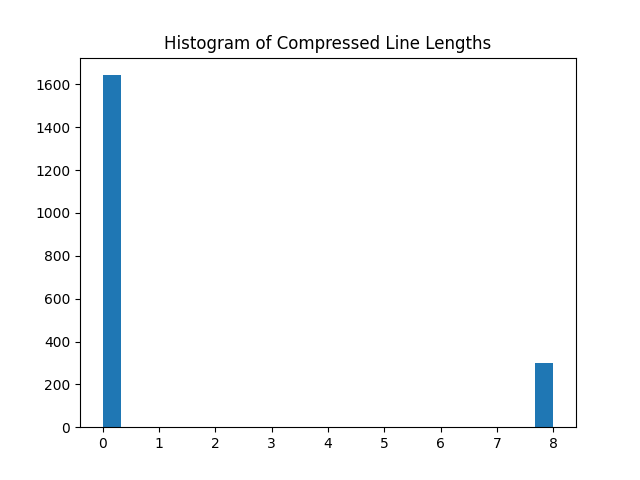

In [13]:
# Histogram of compressed line lengths:
compressed_line_lengths = [len(cld) for cld in compressed_lines]
plt.figure()
plt.hist(compressed_line_lengths, bins=25)
plt.title('Histogram of Compressed Line Lengths')
plt.show()

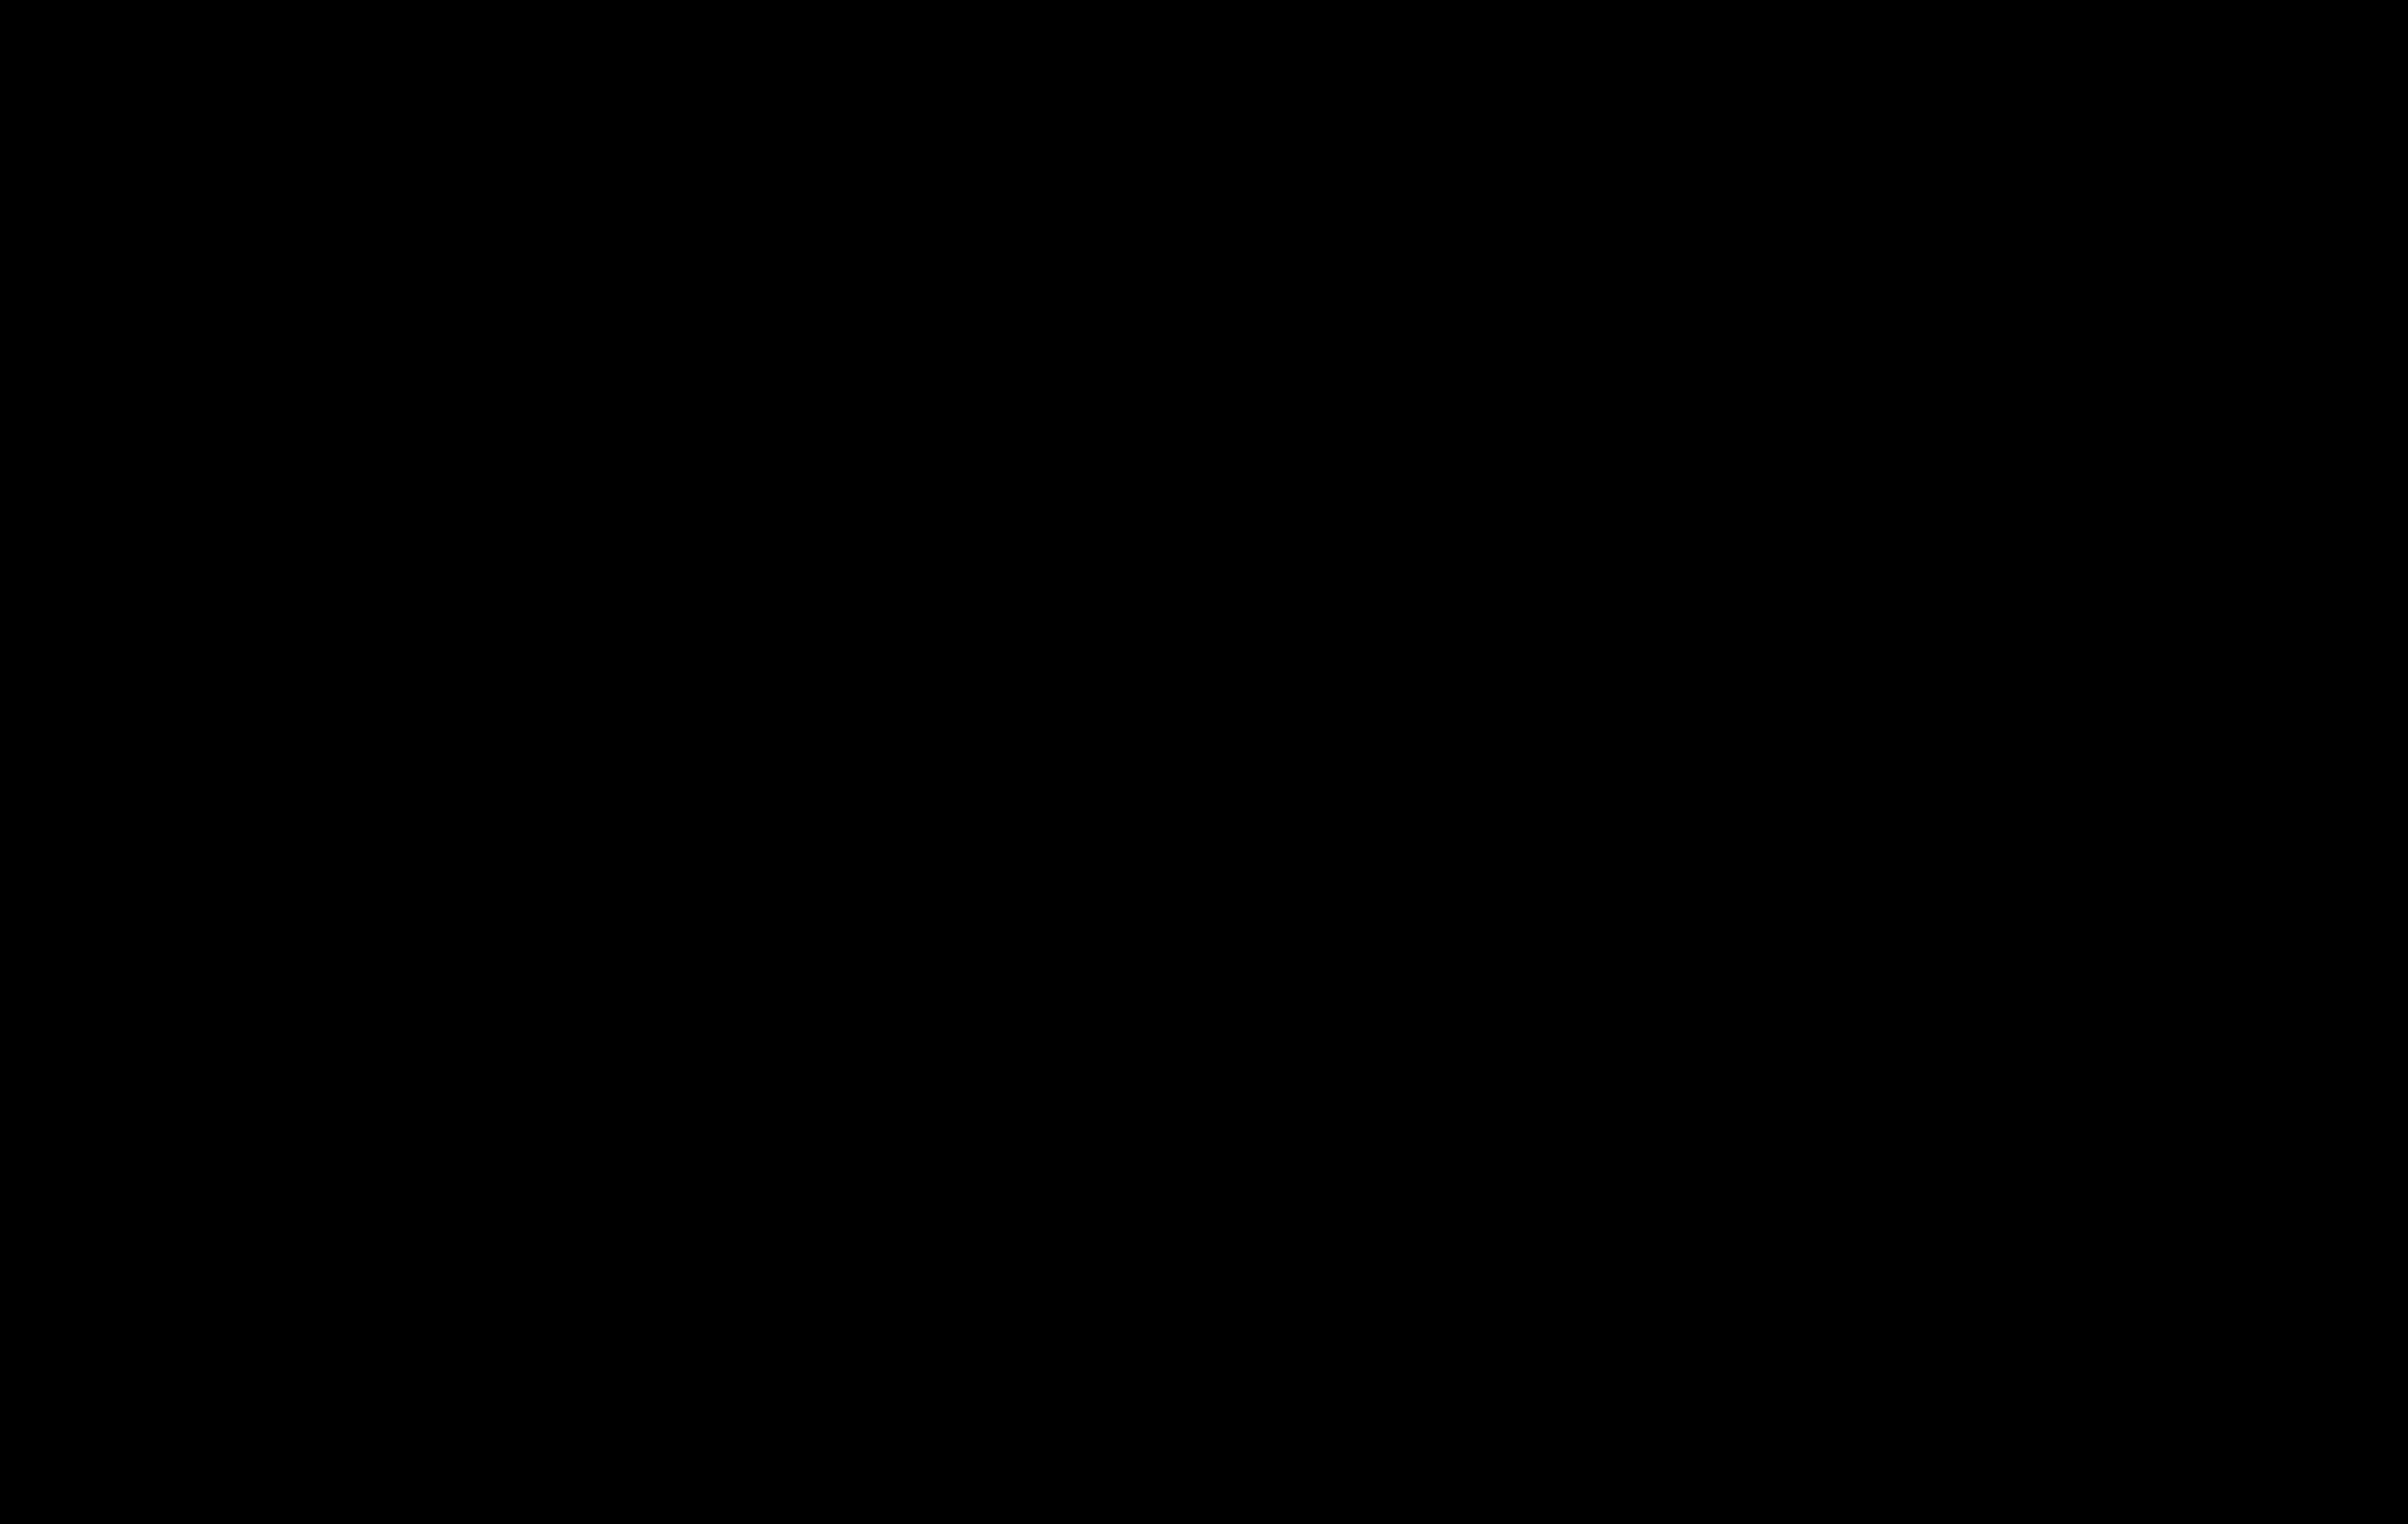

In [14]:
pil = PIL.Image.fromarray(image.astype('uint8'), 'L').rotate(180)
pil.save(image_pickle_file.replace(".pkl", ".quick.png"))
pil

Interim Image interpolation failed b/c `input data must be at least 2-D`. Defaulting to fill with `0`.


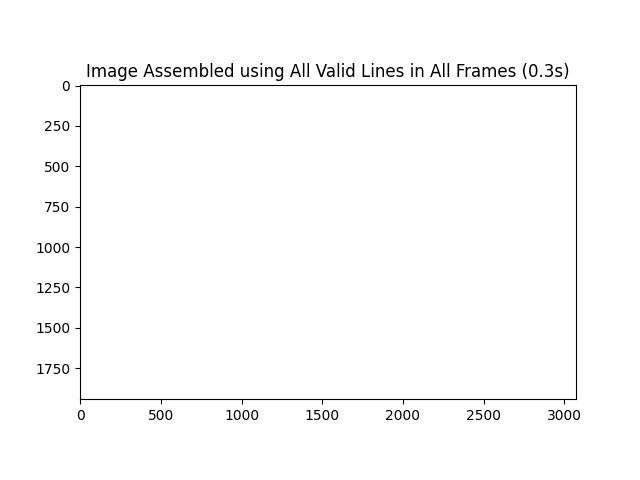

In [15]:
# Intelligently build a whole image from all valid lines in all frames:
start_sec = time.time()
full_image = image_data.smart_build()
end_sec = time.time()

plt.figure()
plt.imshow(full_image, cmap='gray')
plt.title(f'Image Assembled using All Valid Lines in All Frames ({end_sec-start_sec:.01f}s)')
plt.show()

## Median & Mean of Frame Stack:

In [16]:
start_sec = time.time()
median_of_frames = image_data.build_median_frame()
end_sec = time.time()

plt.figure()
plt.imshow(median_of_frames, cmap='gray')
plt.title(f"Median of All Frames ({end_sec-start_sec:.01f}s)")
plt.show()

IndexError: list index out of range

In [ ]:
## GIF of Frames (in case motion was captured):
gif_name = image_pickle_file.replace(".pkl", ".gif")
start_sec = time.time()
image_data.save_frames_gif(gif_name, rotation=180, unknown_cutoff=0.25)
end_sec = time.time()
f"GIF Build Time: {end_sec-start_sec:.01f}s"

'GIF Build Time: 0.1s'


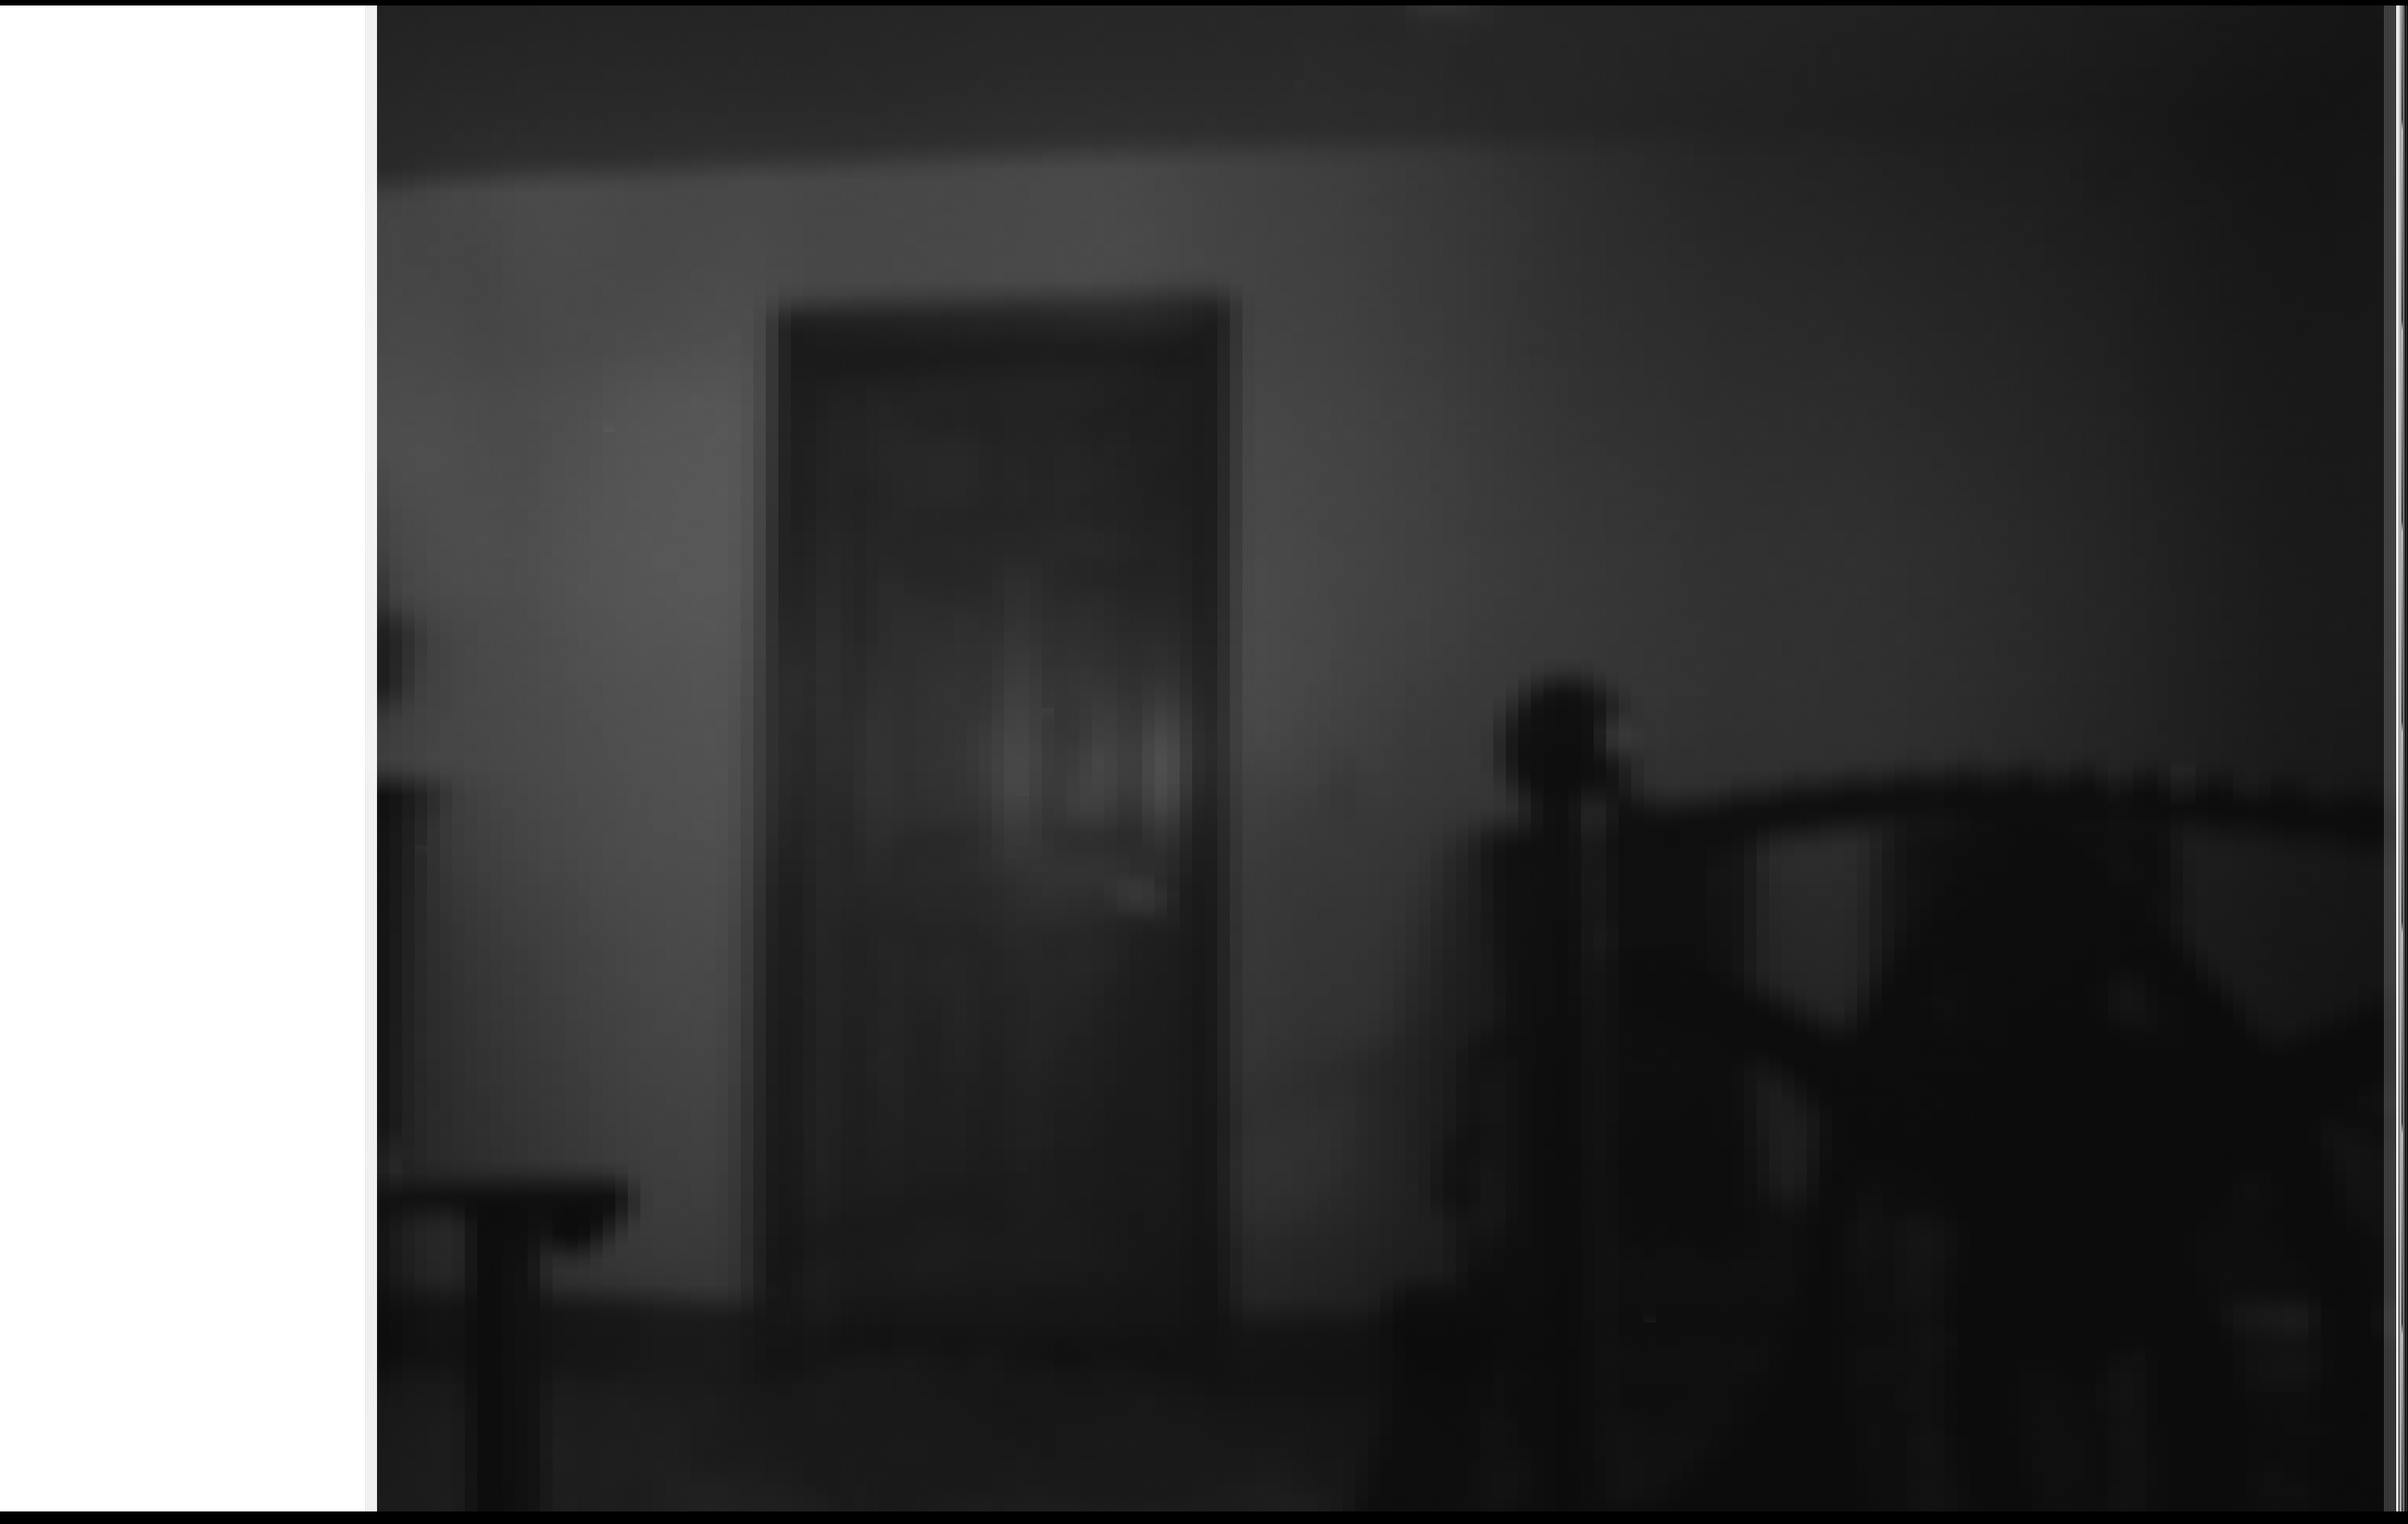

In [ ]:
# Diplay Saved GIF (encode as b64 so it gets saved inside the notebook):
import IPython.display, base64
b64 = base64.b64encode(open(gif_name,'rb').read()).decode('ascii')
IPython.display.display(IPython.display.HTML(f'<img src="data:image/gif;base64,{b64}" />'))

## Summary of Key Images:

### Full "Smart Build" Interpolated Image:

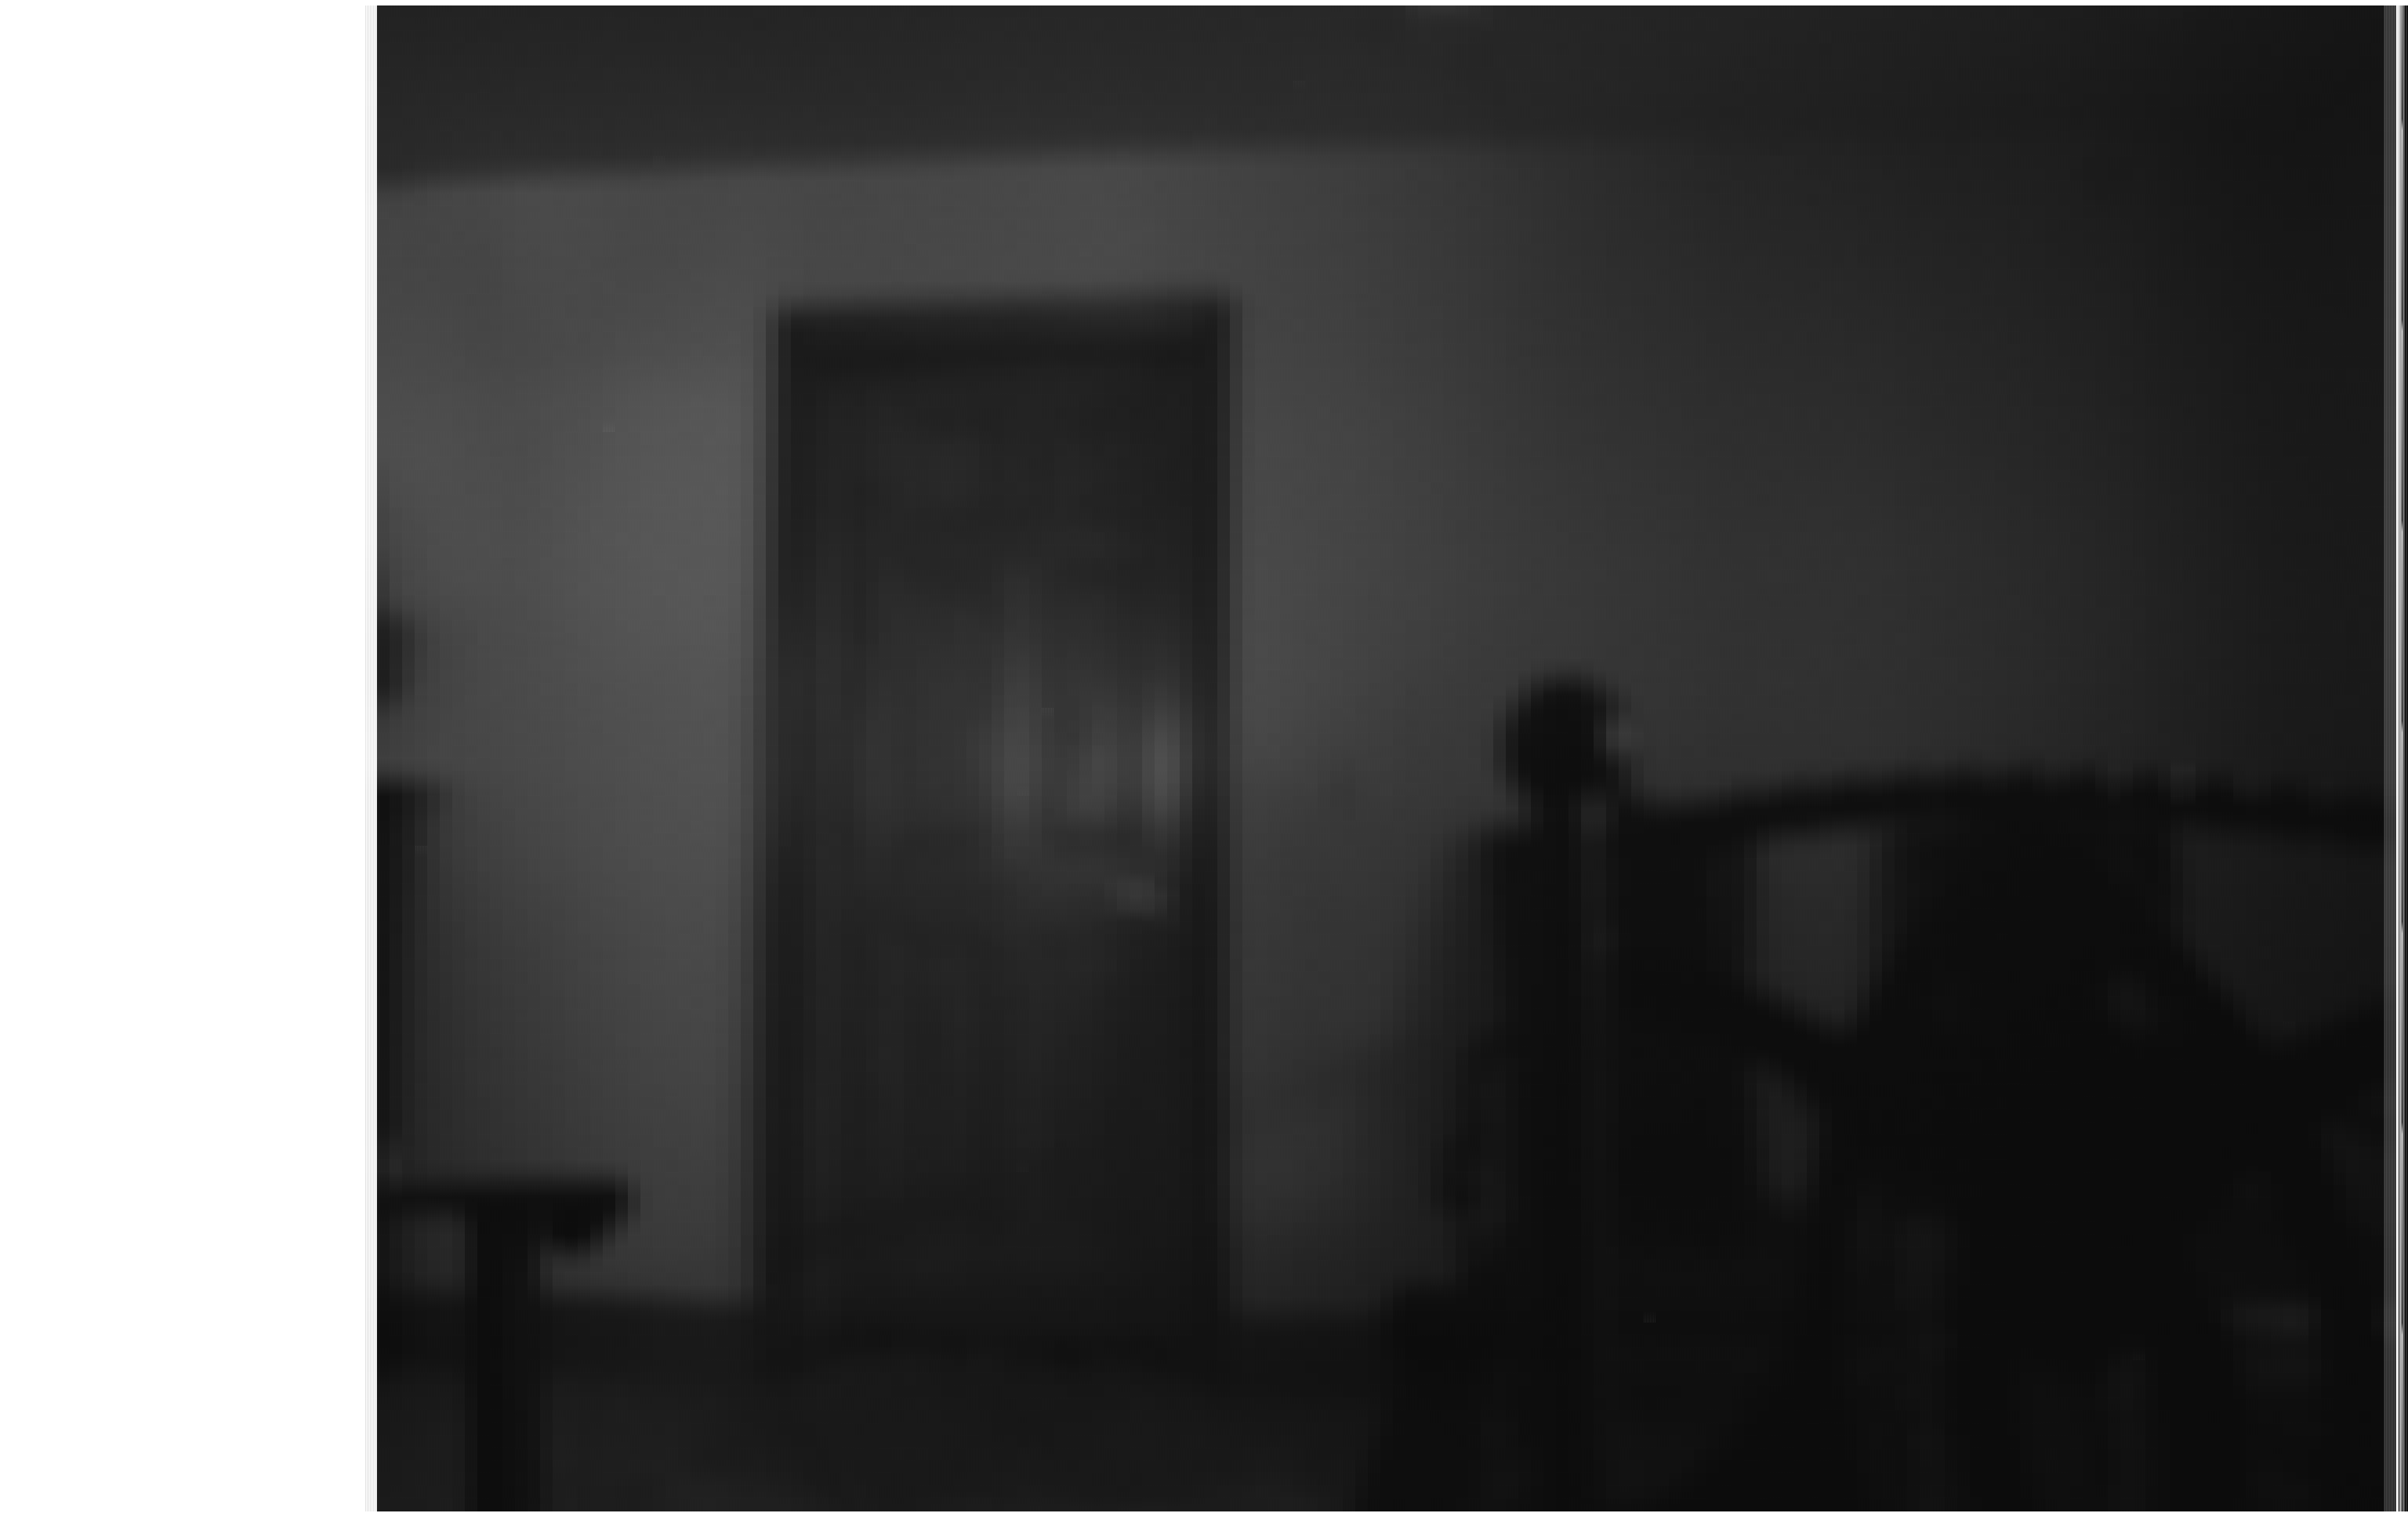

In [ ]:
full_image[np.isnan(full_image)] = 0xFF  # just in case
pil = PIL.Image.fromarray(full_image.astype('uint8'), 'L').rotate(180)
pil.save(image_pickle_file.replace(".pkl", ".interp.png"))
pil

### Median of All (Interpolated) Frames:

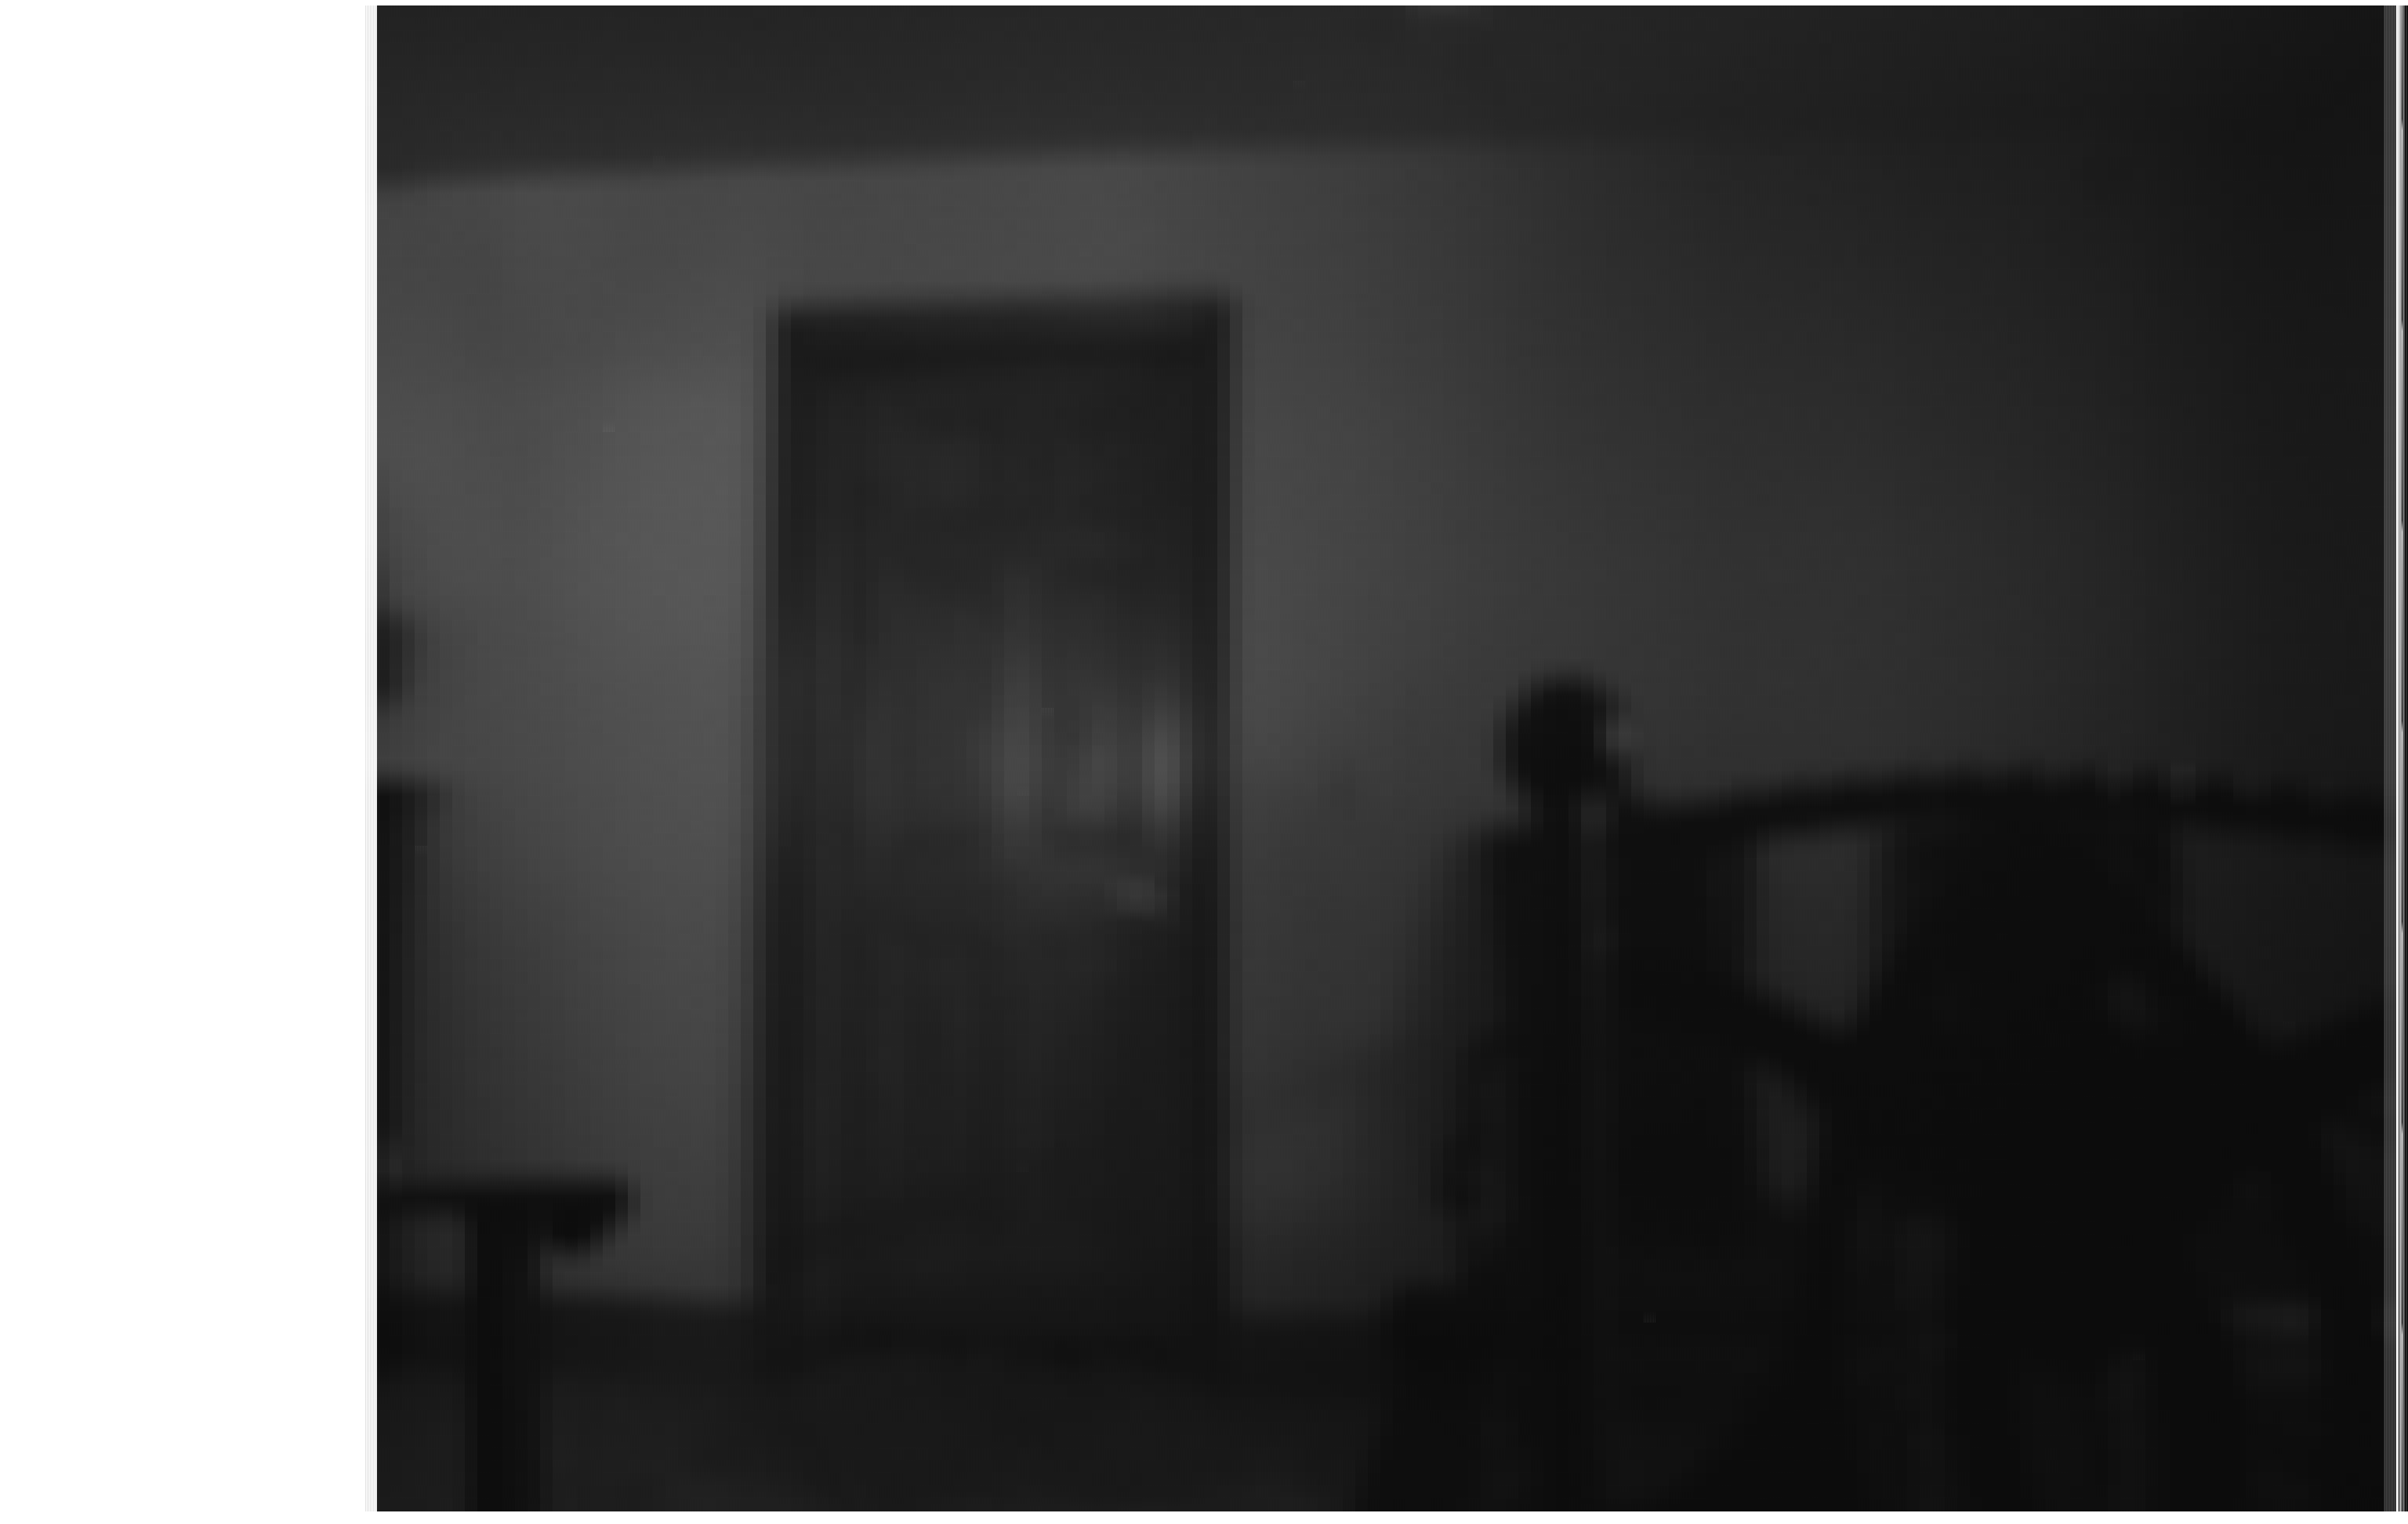

In [ ]:
pil = PIL.Image.fromarray(median_of_frames.astype('uint8'), 'L').rotate(180)
pil.save(image_pickle_file.replace(".pkl", ".median.png"))
pil